In [1]:
import pandas as pd
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from label_map import label2id, id2label

c:\Users\user\anaconda3\envs\test-0602\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1 뉴스 본문 전처리, 요약, 종목명, 업종명, 임베딩

### 1 뉴스 본문 전처리

In [2]:
df = pd.read_csv("../../db/news_2023_2025_summarized.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14087 entries, 0 to 14086
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Unnamed: 0                    14087 non-null  int64 
 1   news_id                       14087 non-null  object
 2   wdate                         14087 non-null  object
 3   title                         14087 non-null  object
 4   article                       14087 non-null  object
 5   press                         14087 non-null  object
 6   url                           14087 non-null  object
 7   image                         14087 non-null  object
 8   article_preprocessed          14087 non-null  object
 9   summary                       14087 non-null  object
 10  stock_list                    14087 non-null  object
 11  industry_list                 14087 non-null  object
 12  summary_embedding             14087 non-null  object
 13  summary_embeddin

In [7]:
df.columns

Index(['Unnamed: 0', 'news_id', 'wdate', 'title', 'article', 'press', 'url',
       'image', 'article_preprocessed', 'summary', 'stock_list',
       'industry_list', 'summary_embedding', 'summary_embedding_encoded_32'],
      dtype='object')

In [8]:
df = df[['news_id', 'wdate', 'title', 'article', 'press', 'url',
       'image', 'article_preprocessed', 'summary', 'stock_list',
       'industry_list']]

In [9]:
df.head(1)

,news_id,wdate,title,article,press,url,image,article_preprocessed,summary,stock_list,industry_list
0,20250523_0002,2025-05-23 18:52:00,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 후끈",매각가 5000억 안팎 달할듯\n결제시장 내 입지강화 포석\n카카오페이 [사진 = ...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,매각가 5000억 안팎 달할듯 결제시장 내 입지강화 포석 카카오페이 국내 대표 전...,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업']


In [6]:
import re
from kss import split_sentences

def remove_market_related_sentences(text: str) -> str:
    # 줄바꿈 제거
    text = text.replace("\n", " ")

    # 대괄호 포함 텍스트 제거: [파이낸셜뉴스], [사진] 등
    text = re.sub(r"\[[^\]]*\]", "", text)

    # '/사진', '/사진제공' 제거
    text = re.sub(r"/사진(제공)?", "", text)

    # 이메일 주소 제거 (예: josh@yna.co.kr)
    text = re.sub(r"\b[\w.-]+@[\w.-]+\.\w+\b", "", text)

    # 문장 단위 분리 (간단하게 마침표 기준, 필요시 KSS 등 적용 가능)
    sentences = split_sentences(text)

    # 제거할 패턴들 (뉴스 문장에서 자주 등장하는 패턴)
    patterns = [
        r"(자세한 내용|자세한 사항)",  # 뉴스 기본 표현
        r"\d{4}[.-]\d{1,2}[.-]\d{1,2}",  # 날짜 (예: 2025.03.26, 2024-12-01)
        r"([0-9,]+(?:만)?[0-9,]*\s?(?:원|만원))",  # 가격 (예: 3,500원, 12000원)
        r"(강세|펀드|시가총액|등락률|한국거래소)",  # 증시 용어
        r"\([+-]?[0-9.,]+%\)",  # 괄호 안 퍼센트 등락률
        r"(투자의견|연구원|평가|예상치|증권가|리포트|팀장)",  # 애널리스트 용어
        r"(순이익|전년|매출|영업이익|영업적자|증시|코스피|코스닥|다우|나스닥|매출액|거래일|호조세|레버리지|투자자|조정|자산|수익률|이익률|수익성|내리막|부진한|낙폭|기대치|실적발표|기업 가치)",  # 시장 용어
    ]

    # 하나의 통합 패턴으로 컴파일
    combined_pattern = re.compile("|".join(patterns))

    # 필터링된 문장만 유지
    filtered = [s for s in sentences if not combined_pattern.search(s)]

    text_preprocessed = " ".join(filtered)

    # print(f"원문:{sentences}\n|\n전처리 된 문장: {text_preprocessed}\n\n")

    return text_preprocessed

In [25]:
from tqdm import tqdm

tqdm.pandas()  # 이거 반드시 호출해야 함

df["article_preprocessed"] = df[
    "article"
].progress_apply(remove_market_related_sentences)

100%|██████████| 58405/58405 [28:07<00:00, 34.61it/s]  


In [30]:
def drop_article_preprocessed(df):
    # 전처리된 문장 길이 구하기
    df["article_preprocessed_len"] = df[
        "article_preprocessed"
    ].apply(lambda x: len(x))

    # 전처리된 문장 길이가 70 이상인 것만 필터링
    df = df[
        df["article_preprocessed_len"] > 70
    ]

    df = df.drop(columns=["article_preprocessed_len"])

    return df

In [31]:
df = drop_article_preprocessed(df)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53202 entries, 0 to 58404
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   news_id               53202 non-null  object
 1   wdate                 53202 non-null  object
 2   title                 53202 non-null  object
 3   article               53202 non-null  object
 4   press                 53202 non-null  object
 5   url                   53202 non-null  object
 6   image                 53202 non-null  object
 7   article_preprocessed  53202 non-null  object
dtypes: object(8)
memory usage: 3.7+ MB


### 2 뉴스 본문 요약

In [20]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# 모델 이름
model_summarize_name1 = "digit82/kobart-summarization"

# 토크나이저 & 모델 로드
tokenizer_summarize1 = AutoTokenizer.from_pretrained(model_summarize_name1)
model_summarize1 = AutoModelForSeq2SeqLM.from_pretrained(
    model_summarize_name1, use_safetensors=True
)

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_summarize1.to(device)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_lay

In [33]:
def summarize_event_focused(text):
    # 토크나이징 및 텐서 변환 (GPU로 올리기)
    inputs = tokenizer_summarize1(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    input_ids = inputs["input_ids"].to(device)

    text_length = len(text)

    # 1. 최소 길이는 짧은 본문은 고정, 긴 본문은 점진적으로 증가
    def compute_min_length(text_length: int) -> int:
        if text_length < 300:
            return 30
        else:
            return 50

    min_len = compute_min_length(text_length)
    max_len = round(text_length * 0.5) + 50  # 더 여유를 주되 max 길이 제한

    # 2. generate 최적 설정
    summary_ids = model_summarize1.generate(
        input_ids,
        min_length=min_len,
        max_new_tokens=max_len,
        num_beams=4,  # 4보다 빠름. 품질도 비슷
        length_penalty=1.0,  # 길이 패널티 완화
        repetition_penalty=1.3,  # 반복 억제 강화
        no_repeat_ngram_size=3,  # 반복 문장 방지
        early_stopping=True,
        do_sample=False,  # 일관된 요약
    )

    return tokenizer_summarize1.decode(summary_ids[0], skip_special_tokens=True)


def print_summary(df, max_tokens=128):
    for i, row in tqdm(df.iterrows(), total=len(df)):
        try:
            text = row["article_preprocessed"]
            summary = summarize_event_focused(text)
            print(f"\n📝 뉴스 {i}\n\n본문: {text} \n\n요약: {summary}\n")
        except Exception as e:
            print(f"❌ 요약 실패: {e}")

In [34]:
print_summary(df[:3])

 33%|███▎      | 1/3 [00:04<00:09,  4.57s/it]


📝 뉴스 0

본문: 2035년 종료 앞둬, 존속 공약에 기대감 창업 초기자금 공백 완화 가능성에 업계 안도 VC, "정책 연속성 중요…불확실성 줄어야" 퇴직연금도 벤처로…BDC 등 활성화 방안 포함 이 기사는 2025년05월23일 17시10분에 마켓인 프리미엄 콘텐츠 로 선공개 되었습니다. 23일 관련업계에 따르면 이 후보는 해당 공약을 ‘벤처·스타트업 10대 공약’의 하나로 포함시키며, 벤처 투자 인프라를 제도적으로 보완하겠다는 의지를 내비쳤다. 업계에서는 단기 예산 복원이 아닌, 정책 연속성에 무게를 둔 점에 주목하고 있다. 글로벌 대비 민간 자본의 투자 여력이 제한적인 한국 벤처 시장 특성상, 정부 출자의 존재감은 그만큼 절대적이다. 이에 따라 벤처캐피털(VC) 업계에서는 이재명 후보의 공약이 단순한 예산 복원을 넘어 구조적인 불확실성 해소에 방점을 두고 있다는 점에서 긍정적으로 받아들이는 분위기다. 이 후보는 이외에도 퇴직연금의 벤처투자 허용, 연기금 투자풀의 벤처투자 확대, 기업 성장집합투자기구(BDC) 도입 등 다양한 벤처투자 활성화 방안을 함께 제시하며 투자 생태계 전반의 구조 개편 의지를 밝혔다. 

요약: 이재명 후보의 벤처투자 허용, 연기금 투자풀의 벤처투자 확대, 기업 성장집합투자기구(BDC) 도입 등 다양한 벤처투자 활성화 방안을 함께 제시하며 투자 생태계 전반의 구조 개편 의지를 내비쳤다.   



 67%|██████▋   | 2/3 [00:06<00:02,  2.82s/it]


📝 뉴스 1

본문: 매각가 5000억 안팎 달할듯 결제시장 내 입지강화 포석 카카오페이  국내 대표 전자결제사업자인 카카오페이가 신세계이마트 산하 간편결제사업부 인수에 나섰다. 네이버페이·토스페이에 대항해 시장 점유율을 늘리려는 포석으로 해석된다. 23일 정보기술(IT)·투자은행(IB) 업계에 따르면 카카오페이가 SSG닷컴 쓱페이와 G마켓 스마일페이 인수를 위해 신세계이마트 측과 협상을 진행 중인 것으로 파악됐다. 업계에서는 매각가가 5000억원 안팎에 달할 것으로 전망했다. 카카오페이는 약 2500만명의 이용자를 보유한 쓱페이·스마일페이를 인수할 경우 사업 외연을 확대할 수 있다. 매각 작업에 정통한 업계 고위 관계자는 “카카오페이가 결제시장 내 입지 강화를 위해 신세계이마트와 결제사업 부문 인수 등 다양한 방안에 대해 논의 중인 것으로 안다”고 전했다. 신세계이마트 측은 “매각을 재추진중인 건 맞지만 아직 정해진 것은 없다”고 밝혔다. 신세계이마트는 지난 해 토스와 결제사업 매각을 논의하다 결렬된 바 있다. 

요약: 23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카카오페이가 SSG닷컴 쓱페이와 G마켓 스마일페이 인수를 위해 신세계이마트 측과 협상을 진행 중인 것으로 알려졌다.



100%|██████████| 3/3 [00:07<00:00,  2.35s/it]


📝 뉴스 2

본문: 총 2166대1의 경쟁률을 기록, 청약 증거금 6조원을 모으는 데 성공했다. 지난 22일부터 이날까지 양간 일반 청약을 진행한 결과 최종 경쟁률은 총 2166.01대1로  집계됐다. 청약 건수는 19만1049건으로, 청약 금액의 절반을 미리 내는 청약증거금은 약 6조1400억원이 모였다. 키스트론은 고려제강그룹 계열사로 1992년 설립됐다. 철선에 구리를 도금한 동복강선 리드 와이어가 핵심 제품으로, 글로벌 시장에서 약 18% 점유율을 갖췄다. 이번 공모를 통해 226억 원을 조달한다. 주관사는 신한투자증권이 맡았다. 

요약: 고려제강그룹 계열사로 1992년 설립된 키스트론은 지난 22일부터 양간 일반 청약을 진행한 결과 최종 경쟁률은 총 2166.01대1로 집계됐다.



In [37]:
df = df[:20000]

In [38]:
df["summary"] = df[
    "article_preprocessed"
].progress_apply(summarize_event_focused)

100%|██████████| 20000/20000 [8:47:08<00:00,  1.58s/it]  


### 3 뉴스 종목 매칭하기

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from label_map import label2id, id2label

model_name = "KPF/KPF-BERT-NER"

# 토크나이저와 모델 불러오기
tokenizer_ner = AutoTokenizer.from_pretrained(model_name)
model_ner = AutoModelForTokenClassification.from_pretrained(
    model_name, use_safetensors=True
)

# 라벨 매핑 반영
model_ner.config.label2id = label2id
model_ner.config.id2label = id2label

tokenizer_ner.model_max_length = 512

# 디바이스 설정
device = 0 if torch.cuda.is_available() else -1

# NER 파이프라인 생성 (GPU 사용)
ner_pipeline = pipeline(
    task="ner",
    model=model_ner,
    tokenizer=tokenizer_ner,
    aggregation_strategy="simple",
    framework="pt",
    device=device,
)

/opt/anaconda3/envs/test-0603/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu


In [42]:
import pandas as pd

df_meta2 = pd.read_csv('../../db/news_2023_2025_metadata2.csv')
df_meta2.head()

,Unnamed: 0,news_id,summary,stock_list,stock_list_view,industry_list,impact_score
0,0,20250523_0002,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,"[{'stock_id': '377300', 'stock_name': '카카오페이'}]",[],"[{'stock_id': '377300', 'industry_id': '116601...",0.33
1,1,20250523_0004,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,"[{'stock_id': '005930', 'stock_name': '삼성전자'}]",[],"[{'stock_id': '005930', 'industry_id': '32604'...",0.05
2,2,20250523_0007,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 카카오페이가 SSG닷컴 쓱페이...,"[{'stock_id': '377300', 'stock_name': '카카오페이'}]",[],"[{'stock_id': '377300', 'industry_id': '116601...",0.33
3,3,20250523_0010,23일 효성중공업은 조 회장이 상속세 재원을 마련하기 위해 시간 외 매매로 효성중 ...,"[{'stock_id': '298040', 'stock_name': '효성중공업'}]",[],"[{'stock_id': '298040', 'industry_id': '32801'...",0.08
4,4,20250523_0011,카카오페이가 신세계 이마트 측에서 쓱페이·스마일페이 인수를 추진하고 나선 건 국내 ...,"[{'stock_id': '377300', 'stock_name': '카카오페이'}]",[],"[{'stock_id': '377300', 'industry_id': '116601...",0.33


In [9]:
df = pd.read_csv('../../db/news_2023_2025_raw.csv')
df.head()

,news_id,wdate,title,article,press,url,image
0,20250523_0002,2025-05-23 18:52:00,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 후끈",매각가 5000억 안팎 달할듯\n결제시장 내 입지강화 포석\n카카오페이 [사진 = ...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...
1,20250523_0004,2025-05-23 18:33:00,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다",[사진=연합뉴스]\n세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...
2,20250523_0007,2025-05-23 18:00:00,[단독] 전자결제 강자 카카오페이 쓱·스마일 페이 인수 추진,국내 대표 전자결제사업자인 카카오페이가 신세계이마트 산하 간편결제사업부 인수에 나섰...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://ssl.pstatic.net/static.news/image/news...
3,20250523_0010,2025-05-23 17:52:00,조현준 효성重 지분 4.9% 美 테크펀드 2600억 매각,조현준 효성 회장이 상속세 재원 마련을 위해 효성중공업 지분 4.90%를 미국의 글...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://ssl.pstatic.net/static.news/image/news...
4,20250523_0011,2025-05-23 17:52:00,몸집 키우는 카카오…'간편결제 빅3' 흔드나,"카카오페이, 신세계 페이 품나\n이커머스 결제 강화 점유 확대\n압도적 1위 네이버...",매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...


In [43]:
def extract_ner(text):
    entities = ner_pipeline(text)
    results = []
    seen = set()

    for ent in entities:
        word = ent["word"].replace("##", "").strip()
        tag = ent["entity_group"]

        score = ent["score"]

        if word and score >= 0.95 and (word, tag) not in seen:
            results.append((word, tag))
            seen.add((word, tag))

    return results


def get_stock_names(text):
    ner_list = extract_ner(text)

    # OGG_ECONOMY만 필터링하여 종목명만 리스트로 추출
    stock_names = [ent[0] for ent in ner_list if ent[1] == "OGG_ECONOMY"]

    return stock_names

In [ ]:
from tqdm import tqdm

tqdm.pandas()

df_meta["stock_list"] = df["summary"].progress_apply(get_stock_names)

In [ ]:
from tqdm import tqdm

tqdm.pandas()

df_meta2["stock_list_view"] = df["article"].progress_apply(
    get_stock_names
)

  2%|▏         | 241/14087 [02:05<2:48:30,  1.37it/s]

In [11]:
df_meta.head()

,news_id,summary,stock_list,industry_list,impact_score,stock_list_view
0,20250523_0002,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,"[""카카오페이""]","[""금융 지원 서비스업""]",0.33,"[카카오페이, 신세계이마트, 토스]"
1,20250523_0004,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,"[""삼성전자""]","[""통신 및 방송 장비 제조업""]",0.05,"[골드만삭스, 한국은행, 삼성전자, MBK파트너스, 월드론]"
2,20250523_0007,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 카카오페이가 SSG닷컴 쓱페이...,"[""카카오페이""]","[""금융 지원 서비스업""]",0.33,"[카카오페이, 신세계이마트, 토스]"
3,20250523_0010,23일 효성중공업은 조 회장이 상속세 재원을 마련하기 위해 시간 외 매매로 효성중 ...,"[""효성중공업""]","[""전동기, 발전기 및 전기 변환 · 공급 · 제어 장치 제조업""]",0.08,"[효성, 효성중공업, 효성 ( 주 )]"
4,20250523_0011,카카오페이가 신세계 이마트 측에서 쓱페이·스마일페이 인수를 추진하고 나선 건 국내 ...,"[""카카오페이""]","[""금융 지원 서비스업""]",0.33,"[카카오페이, 네이버, 신세계 이마트, 스마일페이, 한국은행, 네이버페이, 토스페이..."


In [41]:
# 종목명이 1개 이상, 4개 이하인 뉴스만 필터링하기

df["stock_list_len"] = df["stock_list"].apply(lambda x: len(x))

df = df[(df["stock_list_len"] >= 1) & (df["stock_list_len"] <= 4)]

df = df.drop(columns=["stock_list_len"])

In [12]:
df_krx = pd.read_csv("../../db/KRX_KOSPI.csv", encoding="cp949")
df_krx.head()

,종목코드,종목명,종가,대비,등락률,상장시가총액
0,5930,삼성전자,55700,1800,3.34,329723832.0
1,660,SK하이닉스,208000,5500,2.72,151424492.0
2,207940,삼성바이오로직스,1029000,3000,0.29,73238046.0
3,373220,LG에너지솔루션,282500,10000,3.67,66105000.0
4,12450,한화에어로스페이스,884000,-3000,-0.34,41809842.0


In [25]:
df_krx["종목코드"] = df_krx["종목코드"].astype(str).str.zfill(6)

In [ ]:
import ast

stock_all_list = df_krx["종목명"].dropna().tolist()

# stock_list 컬럼을 필터링
def filter_official_stocks(stock_list):
    if isinstance(stock_list, str):
        try:
            stock_list = ast.literal_eval(stock_list)
        except Exception:
            return []
    if not isinstance(stock_list, list):
        return []

    return [stock for stock in stock_list if stock in stock_all_list]


# 적용
df_meta["stock_list_view"] = df_meta["stock_list_view"].apply(filter_official_stocks)

In [24]:
df_meta[:20]

,news_id,summary,stock_list,industry_list,impact_score,stock_list_view
0,20250523_0002,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,"[""카카오페이""]","[""금융 지원 서비스업""]",0.33,[카카오페이]
1,20250523_0004,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,"[""삼성전자""]","[""통신 및 방송 장비 제조업""]",0.05,[삼성전자]
2,20250523_0007,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 카카오페이가 SSG닷컴 쓱페이...,"[""카카오페이""]","[""금융 지원 서비스업""]",0.33,[카카오페이]
3,20250523_0010,23일 효성중공업은 조 회장이 상속세 재원을 마련하기 위해 시간 외 매매로 효성중 ...,"[""효성중공업""]","[""전동기, 발전기 및 전기 변환 · 공급 · 제어 장치 제조업""]",0.08,"[효성, 효성중공업]"
4,20250523_0011,카카오페이가 신세계 이마트 측에서 쓱페이·스마일페이 인수를 추진하고 나선 건 국내 ...,"[""카카오페이""]","[""금융 지원 서비스업""]",0.33,[카카오페이]
5,20250523_0012,미국 빅테크 기업들의 인공지능(AI) 투자 붐에 힘입어 최근 한 달 동안 주가가 3...,"[""효성중공업""]","[""전동기, 발전기 및 전기 변환 · 공급 · 제어 장치 제조업""]",0.08,"[효성, 효성중공업]"
6,20250523_0015,NH투자증권에서 파생상품 부문 ‘스타 애널리스트’로 이름을 알린 최 VP는 2021...,"[""NH투자증권""]","[""금융 지원 서비스업""]",0.12,[NH투자증권]
7,20250523_0028,삼성바이오로직스는 전날 22일 바이오의약품 개발 및 상업화 사업을 분할해 신설법인(...,"[""삼성바이오로직스""]","[""기초 의약물질 제조업""]",0.09,[삼성바이오로직스]
8,20250523_0032,KKR은 전날 장 마감 이후 HD현대마린솔루션 보유 지분에 대한 블록딜을 재추진해 ...,"[""HD현대마린솔루션""]","[""건축기술, 엔지니어링 및 관련 기술 서비스업""]",0.13,[HD현대마린솔루션]
9,20250523_0050,선박 보수 서비스 기업인 HD현대마린솔루션이 2대 주주의 블록딜 소식에 주가가 약세...,"[""HD현대마린솔루션""]","[""건축기술, 엔지니어링 및 관련 기술 서비스업""]",0.13,"[HD현대마린솔루션, HD현대]"


In [26]:
import pandas as pd


# ③ 종목명 → 종목코드 딕셔너리 생성
name_to_code = dict(zip(df_krx["종목명"], df_krx["종목코드"]))

# ④ stock_list를 매핑된 딕셔너리 리스트로 변환하는 함수
import ast


def enrich_stock_list(stock_names_raw):
    try:
        stock_names = ast.literal_eval(stock_names_raw)  # 문자열 리스트 → 실제 리스트
        result = []
        for name in stock_names:
            code = name_to_code.get(name)
            if code:
                result.append({"stock_id": code, "stock_name": name})
        return result
    except Exception:
        return []


# ⑤ 적용
df_meta["stock_list"] = df_meta["stock_list"].apply(enrich_stock_list)

In [30]:
df_meta.head()

,news_id,summary,stock_list,industry_list,impact_score,stock_list_view
0,20250523_0002,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,"[{'stock_id': '377300', 'stock_name': '카카오페이'}]","[""금융 지원 서비스업""]",0.33,[]
1,20250523_0004,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,"[{'stock_id': '005930', 'stock_name': '삼성전자'}]","[""통신 및 방송 장비 제조업""]",0.05,[]
2,20250523_0007,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 카카오페이가 SSG닷컴 쓱페이...,"[{'stock_id': '377300', 'stock_name': '카카오페이'}]","[""금융 지원 서비스업""]",0.33,[]
3,20250523_0010,23일 효성중공업은 조 회장이 상속세 재원을 마련하기 위해 시간 외 매매로 효성중 ...,"[{'stock_id': '298040', 'stock_name': '효성중공업'}]","[""전동기, 발전기 및 전기 변환 · 공급 · 제어 장치 제조업""]",0.08,[]
4,20250523_0011,카카오페이가 신세계 이마트 측에서 쓱페이·스마일페이 인수를 추진하고 나선 건 국내 ...,"[{'stock_id': '377300', 'stock_name': '카카오페이'}]","[""금융 지원 서비스업""]",0.33,[]


In [28]:
# ⑤ 적용
df_meta["stock_list_view"] = df_meta["stock_list_view"].apply(enrich_stock_list)

In [29]:
df_meta.head()

,news_id,summary,stock_list,industry_list,impact_score,stock_list_view
0,20250523_0002,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,"[{'stock_id': '377300', 'stock_name': '카카오페이'}]","[""금융 지원 서비스업""]",0.33,[]
1,20250523_0004,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,"[{'stock_id': '005930', 'stock_name': '삼성전자'}]","[""통신 및 방송 장비 제조업""]",0.05,[]
2,20250523_0007,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 카카오페이가 SSG닷컴 쓱페이...,"[{'stock_id': '377300', 'stock_name': '카카오페이'}]","[""금융 지원 서비스업""]",0.33,[]
3,20250523_0010,23일 효성중공업은 조 회장이 상속세 재원을 마련하기 위해 시간 외 매매로 효성중 ...,"[{'stock_id': '298040', 'stock_name': '효성중공업'}]","[""전동기, 발전기 및 전기 변환 · 공급 · 제어 장치 제조업""]",0.08,[]
4,20250523_0011,카카오페이가 신세계 이마트 측에서 쓱페이·스마일페이 인수를 추진하고 나선 건 국내 ...,"[{'stock_id': '377300', 'stock_name': '카카오페이'}]","[""금융 지원 서비스업""]",0.33,[]


### 4 뉴스 업종명 매칭하기

In [42]:
df_krx_desc = pd.read_csv("../../db/kospi_description.csv", encoding="cp949")
df_krx_desc.head()

,종목코드,종목명,시장구분,소속부,소속부.1,업종코드,업종명,결산월,지정자문인,상장주식수,액면가,자본금,통화구분,대표이사,대표전화,주소
0,95570,AJ네트웍스,KOSPI,NaN,NaN,147603,산업용 기계 및 장비 임대업,12,NaN,45252759,1000,46822295000,원(KRW),곽정호,02-6363-9999,"서울특별시 송파구 정의로8길 9 (문정동,AJ빌딩)"
1,6840,AK홀딩스,KOSPI,NaN,NaN,116409,기타 금융업,12,NaN,13247561,5000,66237805000,원(KRW),"고준, 채형석 (각자 대표이사)",02-768-2923,서울특별시 마포구 양화로 188 -
2,27410,BGF,KOSPI,NaN,NaN,116409,기타 금융업,12,NaN,95716791,1000,95716791000,NaN,홍정국,1577-3663,서울특별시 강남구 테헤란로 405
3,282330,BGF리테일,KOSPI,NaN,NaN,74701,종합 소매업,12,NaN,17283906,1000,17283906000,원(KRW),민승배,02-1577-8007,서울특별시 강남구 테헤란로 405 BGF사옥
4,138930,BNK금융지주,KOSPI,NaN,NaN,116409,기타 금융업,12,NaN,318383519,5000,1629676230000,원(KRW),빈대인,051-620-3023,부산광역시 남구 문현금융로 30(문현동)


In [43]:
# 종목명 → 업종명 매핑 딕셔너리 생성
stock_to_industry = dict(zip(df_krx_desc["종목명"], df_krx_desc["업종명"]))

# 업종명을 리스트로 매핑
def get_industry_list(stock_list):
    return [
        stock_to_industry.get(stock, "")
        for stock in stock_list
        if stock_to_industry.get(stock, "") != ""
    ]

# 새로운 컬럼에 저장
df["industry_list"] = df["stock_list"].apply(get_industry_list)

In [44]:
# 업종명이 1개 이상인 뉴스만 필터링하기

df["industry_list_len"] = df["industry_list"].apply(lambda x: len(x))

df = df[df["industry_list_len"] >= 1]

df = df.drop(columns=["industry_list_len"])

In [31]:
df_krx_desc = pd.read_csv("../../db/KRX_KOSPI_DESCRIPTION.csv", encoding="cp949")
df_krx_desc.head()

,Unnamed: 0,종목코드,종목명,시장구분,소속부,소속부.1,업종코드,업종명,결산월,지정자문인,상장주식수,액면가,자본금,통화구분,대표이사,대표전화,주소
0,0,95570,AJ네트웍스,KOSPI,NaN,NaN,147603,산업용 기계 및 장비 임대업,12,NaN,45252759,1000,46822295000,원(KRW),곽정호,02-6363-9999,"서울특별시 송파구 정의로8길 9 (문정동,AJ빌딩)"
1,1,6840,AK홀딩스,KOSPI,NaN,NaN,116409,기타 금융업,12,NaN,13247561,5000,66237805000,원(KRW),"고준, 채형석 (각자 대표이사)",02-768-2923,서울특별시 마포구 양화로 188 -
2,2,27410,BGF,KOSPI,NaN,NaN,116409,기타 금융업,12,NaN,95716791,1000,95716791000,NaN,홍정국,1577-3663,서울특별시 강남구 테헤란로 405
3,3,282330,BGF리테일,KOSPI,NaN,NaN,74701,종합 소매업,12,NaN,17283906,1000,17283906000,원(KRW),민승배,02-1577-8007,서울특별시 강남구 테헤란로 405 BGF사옥
4,4,138930,BNK금융지주,KOSPI,NaN,NaN,116409,기타 금융업,12,NaN,318383519,5000,1629676230000,원(KRW),빈대인,051-620-3023,부산광역시 남구 문현금융로 30(문현동)


In [32]:
df_krx_desc["종목코드"] = df_krx_desc["종목코드"].astype(str).str.zfill(6)

In [33]:
import pandas as pd

# 3. 종목코드 → 업종 매핑 딕셔너리 만들기
code_to_industry = {
    row["종목코드"]: {
        "industry_id": str(row["업종코드"]),
        "industry_name": row["업종명"],
    }
    for _, row in df_krx_desc.iterrows()
}


# 4. 뉴스에서 stock_list를 기반으로 industry_list 구성
def extract_industries(stock_list):
    industries = []
    seen = set()
    for stock in stock_list:
        stock_id = stock.get("stock_id")
        if stock_id is None:
            continue
        industry = code_to_industry.get(stock_id)
        if industry:
            key = (stock_id, industry["industry_id"])
            if key not in seen:
                seen.add(key)
                industries.append(
                    {
                        "stock_id": stock_id,
                        "industry_id": industry["industry_id"],
                        "industry_name": industry["industry_name"],
                    }
                )
    return industries


# 5. 뉴스 DataFrame 적용
df_meta["industry_list"] = df_meta["stock_list"].apply(extract_industries)

In [34]:
df_meta.head()

,news_id,summary,stock_list,industry_list,impact_score,stock_list_view
0,20250523_0002,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,"[{'stock_id': '377300', 'stock_name': '카카오페이'}]","[{'stock_id': '377300', 'industry_id': '116601...",0.33,[]
1,20250523_0004,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,"[{'stock_id': '005930', 'stock_name': '삼성전자'}]","[{'stock_id': '005930', 'industry_id': '32604'...",0.05,[]
2,20250523_0007,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 카카오페이가 SSG닷컴 쓱페이...,"[{'stock_id': '377300', 'stock_name': '카카오페이'}]","[{'stock_id': '377300', 'industry_id': '116601...",0.33,[]
3,20250523_0010,23일 효성중공업은 조 회장이 상속세 재원을 마련하기 위해 시간 외 매매로 효성중 ...,"[{'stock_id': '298040', 'stock_name': '효성중공업'}]","[{'stock_id': '298040', 'industry_id': '32801'...",0.08,[]
4,20250523_0011,카카오페이가 신세계 이마트 측에서 쓱페이·스마일페이 인수를 추진하고 나선 건 국내 ...,"[{'stock_id': '377300', 'stock_name': '카카오페이'}]","[{'stock_id': '377300', 'industry_id': '116601...",0.33,[]


In [35]:
df_meta.to_csv('../../db/news_2023_2025_metadata2.csv')

In [39]:
df_meta2 = pd.read_csv('../../db/news_2023_2025_metadata2.csv')
df_meta2

,Unnamed: 0,news_id,summary,stock_list,industry_list,impact_score,stock_list_view
0,0,20250523_0002,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,"[{'stock_id': '377300', 'stock_name': '카카오페이'}]","[{'stock_id': '377300', 'industry_id': '116601...",0.33,[]
1,1,20250523_0004,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,"[{'stock_id': '005930', 'stock_name': '삼성전자'}]","[{'stock_id': '005930', 'industry_id': '32604'...",0.05,[]
2,2,20250523_0007,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 카카오페이가 SSG닷컴 쓱페이...,"[{'stock_id': '377300', 'stock_name': '카카오페이'}]","[{'stock_id': '377300', 'industry_id': '116601...",0.33,[]
3,3,20250523_0010,23일 효성중공업은 조 회장이 상속세 재원을 마련하기 위해 시간 외 매매로 효성중 ...,"[{'stock_id': '298040', 'stock_name': '효성중공업'}]","[{'stock_id': '298040', 'industry_id': '32801'...",0.08,[]
4,4,20250523_0011,카카오페이가 신세계 이마트 측에서 쓱페이·스마일페이 인수를 추진하고 나선 건 국내 ...,"[{'stock_id': '377300', 'stock_name': '카카오페이'}]","[{'stock_id': '377300', 'industry_id': '116601...",0.33,[]
...,...,...,...,...,...,...,...
14082,14082,20240101_0001,외국인과 기관이 지난해 12월 삼성전자 주식을 1조4267억원어치 사들이며 전체 주...,"[{'stock_id': '005930', 'stock_name': '삼성전자'}]","[{'stock_id': '005930', 'industry_id': '32604'...",NaN,[]
14083,14083,20240101_0011,오는 8일부터 미국 샌프란시스코에서 열리는 'JP모건 헬스케어 컨퍼런스'에 참여하는...,"[{'stock_id': '128940', 'stock_name': '한미약품'},...","[{'stock_id': '128940', 'industry_id': '32102'...",NaN,[]
14084,14084,20240101_0017,"CJ 제일001040) 제일제당은 유럽, 호주 등에서 영토를 넓힘과 동시에 오카도,...","[{'stock_id': '004370', 'stock_name': '농심'}]","[{'stock_id': '004370', 'industry_id': '31008'...",NaN,[]
14085,14085,20240101_0032,외국인과 기관이 지난해 12월 삼성전자 주식을 1조4267억원어치 사들이며 전체 주...,"[{'stock_id': '005930', 'stock_name': '삼성전자'},...","[{'stock_id': '005930', 'industry_id': '32604'...",NaN,[]


In [40]:
df_meta2 = df_meta2[['news_id', 'summary', 'stock_list', 'stock_list_view', 'industry_list', 'impact_score']]
df_meta2.head()

,news_id,summary,stock_list,stock_list_view,industry_list,impact_score
0,20250523_0002,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,"[{'stock_id': '377300', 'stock_name': '카카오페이'}]",[],"[{'stock_id': '377300', 'industry_id': '116601...",0.33
1,20250523_0004,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,"[{'stock_id': '005930', 'stock_name': '삼성전자'}]",[],"[{'stock_id': '005930', 'industry_id': '32604'...",0.05
2,20250523_0007,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 카카오페이가 SSG닷컴 쓱페이...,"[{'stock_id': '377300', 'stock_name': '카카오페이'}]",[],"[{'stock_id': '377300', 'industry_id': '116601...",0.33
3,20250523_0010,23일 효성중공업은 조 회장이 상속세 재원을 마련하기 위해 시간 외 매매로 효성중 ...,"[{'stock_id': '298040', 'stock_name': '효성중공업'}]",[],"[{'stock_id': '298040', 'industry_id': '32801'...",0.08
4,20250523_0011,카카오페이가 신세계 이마트 측에서 쓱페이·스마일페이 인수를 추진하고 나선 건 국내 ...,"[{'stock_id': '377300', 'stock_name': '카카오페이'}]",[],"[{'stock_id': '377300', 'industry_id': '116601...",0.33


In [41]:
df_meta2.to_csv('../../db/news_2023_2025_metadata2.csv')

In [10]:
df = pd.read_csv("../../db/news_2023_2025_summarized.csv")
df = df[
    [
        "news_id",
        "wdate",
        "title",
        "article",
        "press",
        "url",
        "image",
        "article_preprocessed",
        "summary",
        "stock_list",
        "industry_list",
    ]
]

### 5 뉴스 요약문 임베딩하기

In [11]:
from sentence_transformers import SentenceTransformer
import torch

model_name = "snunlp/KR-SBERT-V40K-klueNLI-augSTS"

# GPU가 있으면 GPU, 없으면 CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# 모델 로딩 후 디바이스 설정
model_emb = SentenceTransformer(model_name, device=device)

In [12]:
embeddings = model_emb.encode(
    df["summary"].tolist(), show_progress_bar=True
)

df["summary_embedding"] = embeddings.tolist()

Batches:   4%|▎         | 16/441 [00:16<07:16,  1.03s/it]


KeyboardInterrupt: 

In [45]:
df.to_csv("../../db/news_2023_2025_summarized.csv")

### 6 임베딩 축소하기

In [13]:
df_summarized = pd.read_csv(('../../db/news_2023_2025_summarized.csv'))
df_summarized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14087 entries, 0 to 14086
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Unnamed: 0                    14087 non-null  int64 
 1   news_id                       14087 non-null  object
 2   wdate                         14087 non-null  object
 3   title                         14087 non-null  object
 4   article                       14087 non-null  object
 5   press                         14087 non-null  object
 6   url                           14087 non-null  object
 7   image                         14087 non-null  object
 8   article_preprocessed          14087 non-null  object
 9   summary                       14087 non-null  object
 10  stock_list                    14087 non-null  object
 11  industry_list                 14087 non-null  object
 12  summary_embedding             14087 non-null  object
 13  summary_embeddin

In [14]:
import ast

df_summarized['summary_embedding'] = df_summarized['summary_embedding'].apply(ast.literal_eval)

In [15]:
import random
import numpy as np
import torch

# 1. 고정 seed 설정
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# (가능하면 GPU 일관성도 위해 다음도 함께)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingAutoencoder(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.1),

            nn.Linear(512, 256),
            nn.GELU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),

            nn.Linear(256, hidden_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.GELU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),

            nn.Linear(256, 512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.1),

            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


# 학습 예시 (단기)
model = EmbeddingAutoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
criterion = nn.MSELoss()

text_emb = df_summarized['summary_embedding']

X = torch.tensor(text_emb, dtype=torch.float32)

for epoch in range(1, 101):
    model.train()
    x_hat, z = model(X)
    loss = criterion(x_hat, X)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}/100, Loss: {loss.item():.6f}")

Epoch 1/100, Loss: 0.654854
Epoch 10/100, Loss: 0.260758
Epoch 20/100, Loss: 0.193229
Epoch 30/100, Loss: 0.133645
Epoch 40/100, Loss: 0.121209
Epoch 50/100, Loss: 0.106783
Epoch 60/100, Loss: 0.099165
Epoch 70/100, Loss: 0.091689
Epoch 80/100, Loss: 0.085783
Epoch 90/100, Loss: 0.080644
Epoch 100/100, Loss: 0.076037


In [17]:
model.eval()

EmbeddingAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): GELU(approximate='none')
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=256, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): GELU(approximate='none')
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [18]:
# 임베딩 압축 결과
with torch.no_grad():
    _, text_emb_ae = model(X)
    text_emb_ae = text_emb_ae.numpy()

In [19]:
df_summarized["summary_embedding_encoded_64"] = text_emb_ae.tolist()

In [22]:
df_summarized.drop(columns=["Unnamed: 0"], inplace=True)

In [23]:
df_summarized.head()

,news_id,wdate,title,article,press,url,image,article_preprocessed,summary,stock_list,industry_list,summary_embedding,summary_embedding_encoded_64
0,20250523_0002,2025-05-23 18:52:00,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 후끈",매각가 5000억 안팎 달할듯\n결제시장 내 입지강화 포석\n카카오페이 [사진 = ...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,매각가 5000억 안팎 달할듯 결제시장 내 입지강화 포석 카카오페이 국내 대표 전...,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],"[-0.21889664232730865, -1.4778014421463013, 0....","[0.18532949686050415, 0.5747820138931274, -2.2..."
1,20250523_0004,2025-05-23 18:33:00,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다",[사진=연합뉴스]\n세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,['삼성전자'],['통신 및 방송 장비 제조업'],"[-0.2798689603805542, -0.5640878081321716, -0....","[-0.04019959270954132, 0.3399140536785126, -1...."
2,20250523_0007,2025-05-23 18:00:00,[단독] 전자결제 강자 카카오페이 쓱·스마일 페이 인수 추진,국내 대표 전자결제사업자인 카카오페이가 신세계이마트 산하 간편결제사업부 인수에 나섰...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://ssl.pstatic.net/static.news/image/news...,국내 대표 전자결제사업자인 카카오페이가 신세계이마트 산하 간편결제사업부 인수에 나섰...,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 카카오페이가 SSG닷컴 쓱페이...,['카카오페이'],['금융 지원 서비스업'],"[-0.5892677903175354, -1.0036863088607788, 0.3...","[0.1704411506652832, 0.9231376647949219, -1.79..."
3,20250523_0010,2025-05-23 17:52:00,조현준 효성重 지분 4.9% 美 테크펀드 2600억 매각,조현준 효성 회장이 상속세 재원 마련을 위해 효성중공업 지분 4.90%를 미국의 글...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://ssl.pstatic.net/static.news/image/news...,효성중공업은 조 회장이 상속세 재원을 마련하기 위해 시간 외 매매로 효성중공업 주식...,23일 효성중공업은 조 회장이 상속세 재원을 마련하기 위해 시간 외 매매로 효성중 ...,['효성중공업'],"['전동기, 발전기 및 전기 변환 · 공급 · 제어 장치 제조업']","[-0.326259970664978, -0.49666550755500793, -0....","[0.8004305958747864, 1.3096638917922974, 0.313..."
4,20250523_0011,2025-05-23 17:52:00,몸집 키우는 카카오…'간편결제 빅3' 흔드나,"카카오페이, 신세계 페이 품나\n이커머스 결제 강화 점유 확대\n압도적 1위 네이버...",매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,"카카오페이, 신세계 페이 품나 이커머스 결제 강화 점유 확대 압도적 1위 네이버에 ...",카카오페이가 신세계 이마트 측에서 쓱페이·스마일페이 인수를 추진하고 나선 건 국내 ...,['카카오페이'],['금융 지원 서비스업'],"[-0.771115779876709, -1.174679160118103, -0.27...","[0.434627503156662, 0.163469135761261, -0.4517..."


In [24]:
df_summarized.to_csv("../../db/news_2023_2025_summarized.csv")

### 6 뉴스 유사도 상위 Top-N개 데이터셋 구성

In [25]:
df_summarized = pd.read_csv("../../db/news_2023_2025_summarized.csv")
# df_summarized = df_summarized.drop(columns=["title", "article", "article_preprocessed", 'url', 'image', 'press'])

In [26]:
df_summarized.head(2)

,Unnamed: 0,news_id,wdate,title,article,press,url,image,article_preprocessed,summary,stock_list,industry_list,summary_embedding,summary_embedding_encoded_64
0,0,20250523_0002,2025-05-23 18:52:00,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 후끈",매각가 5000억 안팎 달할듯\n결제시장 내 입지강화 포석\n카카오페이 [사진 = ...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,매각가 5000억 안팎 달할듯 결제시장 내 입지강화 포석 카카오페이 국내 대표 전...,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],"[-0.21889664232730865, -1.4778014421463013, 0....","[0.18532949686050415, 0.5747820138931274, -2.2..."
1,1,20250523_0004,2025-05-23 18:33:00,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다",[사진=연합뉴스]\n세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,['삼성전자'],['통신 및 방송 장비 제조업'],"[-0.2798689603805542, -0.5640878081321716, -0....","[-0.04019959270954132, 0.3399140536785126, -1...."


In [31]:
df_summarized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14087 entries, 0 to 14086
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Unnamed: 0                    14087 non-null  int64         
 1   news_id                       14087 non-null  object        
 2   wdate                         14087 non-null  datetime64[ns]
 3   title                         14087 non-null  object        
 4   article                       14087 non-null  object        
 5   press                         14087 non-null  object        
 6   url                           14087 non-null  object        
 7   image                         14087 non-null  object        
 8   article_preprocessed          14087 non-null  object        
 9   summary                       14087 non-null  object        
 10  stock_list                    14087 non-null  object        
 11  industry_list               

In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from datetime import timedelta
import ast  # 안전한 문자열 → 파이썬 객체 변환
from tqdm import tqdm

df_summarized["summary_embedding_encoded_64"] = df_summarized["summary_embedding_encoded_64"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# 1. 코사인 유사도 계산
embeddings = np.vstack(df_summarized["summary_embedding_encoded_64"].to_numpy())
similarity_matrix = cosine_similarity(embeddings)

df_summarized["wdate"] = pd.to_datetime(df_summarized["wdate"], errors="coerce")

def extract_top5_similars_with_time_filter(base_idx):
    base_row = df_summarized.iloc[base_idx]
    base_date = base_row["wdate"]

    sims = similarity_matrix[base_idx].copy()
    sims[base_idx] = -1  # 자기 자신 제외

    # 조건 1: 기준 뉴스보다 3개월(90일) 이상 과거
    mask_date_gap = df_summarized["wdate"] < (base_date - timedelta(days=90))
    valid_indices = np.where(mask_date_gap)[0]

    # 유효한 인덱스만 추림
    sims_filtered = [(idx, sims[idx]) for idx in valid_indices]
    sims_sorted = sorted(sims_filtered, key=lambda x: x[1], reverse=True)

    selected_rows = []
    selected_dates = []

    for idx, sim in sims_sorted:
        candidate_date = df_summarized.iloc[idx]["wdate"]

        # 조건 2: 기존 선택된 유사 뉴스들과 1개월(30일) 이상 시차
        if all(abs((candidate_date - d).days) >= 30 for d in selected_dates):
            similar_row = df_summarized.iloc[idx]
            row_data = base_row.to_dict()
            row_data.update(
                {
                    "similarity": sim,
                    "similar_news_id": similar_row["news_id"],
                    "similar_wdate": similar_row["wdate"],
                    "similar_summary": similar_row["summary"],
                    "similar_stock_list": similar_row["stock_list"],
                    "similar_industry_list": similar_row["industry_list"],
                    "similar_summary_embedding_encoded_64": similar_row["summary_embedding_encoded_64"],
                }
            )
            selected_rows.append(row_data)
            selected_dates.append(candidate_date)

        if len(selected_rows) == 5:
            break

    return selected_rows


# 3. 전체 반복
all_rows = []
for i in tqdm(range(len(df_summarized)), total=len(df_summarized)):
    all_rows.extend(extract_top5_similars_with_time_filter(i))

df_final = pd.DataFrame(all_rows)

100%|██████████| 14087/14087 [09:27<00:00, 24.81it/s]  


In [30]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45641 entries, 0 to 45640
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Unnamed: 0                            45641 non-null  int64         
 1   news_id                               45641 non-null  object        
 2   wdate                                 45641 non-null  datetime64[ns]
 3   title                                 45641 non-null  object        
 4   article                               45641 non-null  object        
 5   press                                 45641 non-null  object        
 6   url                                   45641 non-null  object        
 7   image                                 45641 non-null  object        
 8   article_preprocessed                  45641 non-null  object        
 9   summary                               45641 non-null  object        
 10

In [52]:
def has_overlap(list1, list2):
    list1 = ast.literal_eval(list1)
    list2 = ast.literal_eval(list2)

    return int(bool(set(list1) & set(list2)))  # 교집합 존재 여부를 1 또는 0으로 반환

# 적용
df_final["is_similar_stock"] = df_final.apply(
    lambda row: has_overlap(row["stock_list"], row["similar_stock_list"]), axis=1
)

df_final["is_simliar_industry"] = df_final.apply(
    lambda row: has_overlap(row["industry_list"], row["similar_industry_list"]), axis=1
)

In [32]:
df_final.columns

Index(['Unnamed: 0', 'news_id', 'wdate', 'title', 'article', 'press', 'url',
       'image', 'article_preprocessed', 'summary', 'stock_list',
       'industry_list', 'summary_embedding', 'summary_embedding_encoded_64',
       'similarity', 'similar_news_id', 'similar_wdate', 'similar_summary',
       'similar_stock_list', 'similar_industry_list',
       'similar_summary_embedding_encoded_64'],
      dtype='object')

In [35]:
df_final = df_final[
    [
        "news_id",
        "wdate",
        "summary",
        "stock_list",
        "industry_list",
        # 'summary_embedding',
        # 'summary_embedding_encoded_32',
        "similarity",
        # "is_similar_stock",
        # "is_simliar_industry",
        "similar_news_id",
        "similar_wdate",
        "similar_summary",
        "similar_stock_list",
        "similar_industry_list",
        # 'similar_summary_embedding_encoded_32',
    ]
]

<Axes: xlabel='similarity', ylabel='Count'>

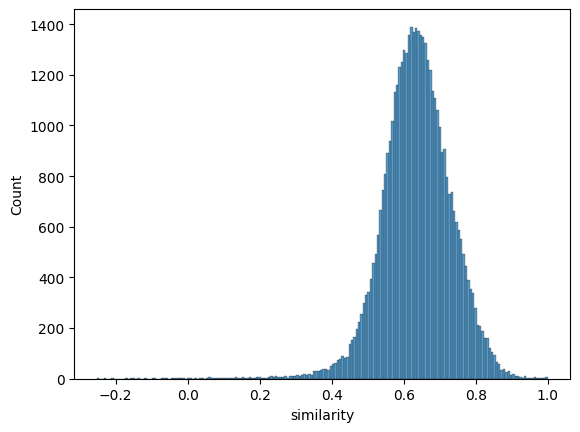

In [36]:
sns.histplot(df_final["similarity"])

In [37]:
df_final['similarity'].describe()

count    45641.000000
mean         0.635966
std          0.096267
min         -0.251688
25%          0.578682
50%          0.636307
75%          0.696763
max          1.000000
Name: similarity, dtype: float64

In [36]:
# 전체 컬럼 내용 출력 제한 해제
pd.set_option("display.max_colwidth", 80)

In [38]:
df_final = df_final[(df_final['similarity'] < 0.95) & (df_final['similarity'] > 0.4)]

In [39]:
df_final.to_csv("../../db/news_2023_2025_dataset_similar_top_5_encoded64.csv", index=False)

In [40]:
df_dataset= pd.read_csv("../../db/news_2023_2025_dataset_similar_top_5_encoded64.csv")

In [41]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45028 entries, 0 to 45027
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   news_id                45028 non-null  object 
 1   wdate                  45028 non-null  object 
 2   summary                45028 non-null  object 
 3   stock_list             45028 non-null  object 
 4   industry_list          45028 non-null  object 
 5   similarity             45028 non-null  float64
 6   similar_news_id        45028 non-null  object 
 7   similar_wdate          45028 non-null  object 
 8   similar_summary        45028 non-null  object 
 9   similar_stock_list     45028 non-null  object 
 10  similar_industry_list  45028 non-null  object 
dtypes: float64(1), object(10)
memory usage: 3.8+ MB


In [42]:
df_dataset.head(2)

,news_id,wdate,summary,stock_list,industry_list,similarity,similar_news_id,similar_wdate,similar_summary,similar_stock_list,similar_industry_list
0,20250523_0002,2025-05-23 18:52:00,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],0.601757,20240913_0041,2024-09-13 16:24:00,"카카오뱅크, 일본 S 스미신넷뱅크, 미국 뱅코프 등 세 곳을 비교기업으로 선정한 케...",['카카오뱅크'],['은행 및 저축기관']
1,20250523_0002,2025-05-23 18:52:00,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],0.570068,20241230_0302,2024-12-30 07:41:00,"지난 26일 이마트는 공시를 통해 알리익스프레스와 G마켓의 지분 출자를 밝혔는데, ...",['이마트'],['종합 소매업']


## 2 뉴스 경제 및 행동 지표 피쳐 추가
- 주가 D+1~D+30 변동률, 금리, 환율, 기관 매매동향, 유가 등

In [43]:
df_external = pd.read_csv("../../db/news_2023_2025_external.csv")

In [44]:
pd.set_option("display.max_columns", None)  # 모든 열 표시

In [45]:
df_external.dropna(inplace=True)

In [46]:
df_external.head(1)

,news_id,d_minus_5_date_close,d_minus_5_date_volume,d_minus_5_date_foreign,d_minus_5_date_institution,d_minus_5_date_individual,d_minus_4_date_close,d_minus_4_date_volume,d_minus_4_date_foreign,d_minus_4_date_institution,d_minus_4_date_individual,d_minus_3_date_close,d_minus_3_date_volume,d_minus_3_date_foreign,d_minus_3_date_institution,d_minus_3_date_individual,d_minus_2_date_close,d_minus_2_date_volume,d_minus_2_date_foreign,d_minus_2_date_institution,d_minus_2_date_individual,d_minus_1_date_close,d_minus_1_date_volume,d_minus_1_date_foreign,d_minus_1_date_institution,d_minus_1_date_individual,d_plus_1_date_close,d_plus_2_date_close,d_plus_3_date_close,d_plus_4_date_close,d_plus_5_date_close,fx,bond10y,base_rate
0,20250523_0116,-0.01,-0.06,-10.64,-0.3,7.55,0.02,0.01,5.7,1.4,-1.42,0.0,0.14,-4.14,0.86,4.79,-0.02,-0.03,-4.79,1.19,5.98,0,0,0,0,0,-0.01,-0.0,-0.01,0.01,0.03,1387.1,2.336,2.75


In [47]:
df_external.columns

Index(['news_id', 'd_minus_5_date_close', 'd_minus_5_date_volume',
       'd_minus_5_date_foreign', 'd_minus_5_date_institution',
       'd_minus_5_date_individual', 'd_minus_4_date_close',
       'd_minus_4_date_volume', 'd_minus_4_date_foreign',
       'd_minus_4_date_institution', 'd_minus_4_date_individual',
       'd_minus_3_date_close', 'd_minus_3_date_volume',
       'd_minus_3_date_foreign', 'd_minus_3_date_institution',
       'd_minus_3_date_individual', 'd_minus_2_date_close',
       'd_minus_2_date_volume', 'd_minus_2_date_foreign',
       'd_minus_2_date_institution', 'd_minus_2_date_individual',
       'd_minus_1_date_close', 'd_minus_1_date_volume',
       'd_minus_1_date_foreign', 'd_minus_1_date_institution',
       'd_minus_1_date_individual', 'd_plus_1_date_close',
       'd_plus_2_date_close', 'd_plus_3_date_close', 'd_plus_4_date_close',
       'd_plus_5_date_close', 'fx', 'bond10y', 'base_rate'],
      dtype='object')

In [49]:
df_external.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13726 entries, 0 to 13748
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   news_id                     13726 non-null  object 
 1   d_minus_5_date_close        13726 non-null  float64
 2   d_minus_5_date_volume       13726 non-null  float64
 3   d_minus_5_date_foreign      13726 non-null  float64
 4   d_minus_5_date_institution  13726 non-null  float64
 5   d_minus_5_date_individual   13726 non-null  float64
 6   d_minus_4_date_close        13726 non-null  float64
 7   d_minus_4_date_volume       13726 non-null  float64
 8   d_minus_4_date_foreign      13726 non-null  float64
 9   d_minus_4_date_institution  13726 non-null  float64
 10  d_minus_4_date_individual   13726 non-null  float64
 11  d_minus_3_date_close        13726 non-null  float64
 12  d_minus_3_date_volume       13726 non-null  float64
 13  d_minus_3_date_foreign      13726 no

In [50]:
def prepare_similarity_training_data(df_pairs, df_external):
    # 외부 피처 prefix: 기본 뉴스용
    base_feats = df_external.copy()
    base_feats.columns = [
        "news_id" if col == "news_id" else col for col in base_feats.columns
    ]

    # 외부 피처 prefix: 유사 뉴스용
    similar_feats = df_external.copy()
    similar_feats.columns = [
        "similar_news_id" if col == "news_id" else f"similar_{col}"
        for col in similar_feats.columns
    ]

    # 병합: 기준 뉴스 외부 변수
    merged = df_pairs.merge(base_feats, on="news_id", how="left")

    # 병합: 유사 뉴스 외부 변수
    merged = merged.merge(similar_feats, on="similar_news_id", how="left")

    # 결측값 제거
    merged = merged.dropna().reset_index(drop=True)

    return merged

In [51]:
df_dataset_merged = prepare_similarity_training_data(df_dataset, df_external)

In [53]:
df_dataset_merged.columns

Index(['news_id', 'wdate', 'summary', 'stock_list', 'industry_list',
       'similarity', 'similar_news_id', 'similar_wdate', 'similar_summary',
       'similar_stock_list', 'similar_industry_list', 'd_minus_5_date_close',
       'd_minus_5_date_volume', 'd_minus_5_date_foreign',
       'd_minus_5_date_institution', 'd_minus_5_date_individual',
       'd_minus_4_date_close', 'd_minus_4_date_volume',
       'd_minus_4_date_foreign', 'd_minus_4_date_institution',
       'd_minus_4_date_individual', 'd_minus_3_date_close',
       'd_minus_3_date_volume', 'd_minus_3_date_foreign',
       'd_minus_3_date_institution', 'd_minus_3_date_individual',
       'd_minus_2_date_close', 'd_minus_2_date_volume',
       'd_minus_2_date_foreign', 'd_minus_2_date_institution',
       'd_minus_2_date_individual', 'd_minus_1_date_close',
       'd_minus_1_date_volume', 'd_minus_1_date_foreign',
       'd_minus_1_date_institution', 'd_minus_1_date_individual',
       'd_plus_1_date_close', 'd_plus_2_date_cl

In [52]:
for col in df_dataset_merged.columns[:133]:
    print(col)

news_id
wdate
summary
stock_list
industry_list
similarity
similar_news_id
similar_wdate
similar_summary
similar_stock_list
similar_industry_list
d_minus_5_date_close
d_minus_5_date_volume
d_minus_5_date_foreign
d_minus_5_date_institution
d_minus_5_date_individual
d_minus_4_date_close
d_minus_4_date_volume
d_minus_4_date_foreign
d_minus_4_date_institution
d_minus_4_date_individual
d_minus_3_date_close
d_minus_3_date_volume
d_minus_3_date_foreign
d_minus_3_date_institution
d_minus_3_date_individual
d_minus_2_date_close
d_minus_2_date_volume
d_minus_2_date_foreign
d_minus_2_date_institution
d_minus_2_date_individual
d_minus_1_date_close
d_minus_1_date_volume
d_minus_1_date_foreign
d_minus_1_date_institution
d_minus_1_date_individual
d_plus_1_date_close
d_plus_2_date_close
d_plus_3_date_close
d_plus_4_date_close
d_plus_5_date_close
fx
bond10y
base_rate
similar_d_minus_5_date_close
similar_d_minus_5_date_volume
similar_d_minus_5_date_foreign
similar_d_minus_5_date_institution
similar_d_minu

In [54]:
df_dataset_merged = df_dataset_merged[
    [
        "news_id",
        "wdate",
        "summary",
        "stock_list",
        "industry_list",
        "d_minus_5_date_close",
        "d_minus_5_date_volume",
        "d_minus_5_date_foreign",
        "d_minus_5_date_institution",
        "d_minus_5_date_individual",
        "d_minus_4_date_close",
        "d_minus_4_date_volume",
        "d_minus_4_date_foreign",
        "d_minus_4_date_institution",
        "d_minus_4_date_individual",
        "d_minus_3_date_close",
        "d_minus_3_date_volume",
        "d_minus_3_date_foreign",
        "d_minus_3_date_institution",
        "d_minus_3_date_individual",
        "d_minus_2_date_close",
        "d_minus_2_date_volume",
        "d_minus_2_date_foreign",
        "d_minus_2_date_institution",
        "d_minus_2_date_individual",
        "d_minus_1_date_close",
        "d_minus_1_date_volume",
        "d_minus_1_date_foreign",
        "d_minus_1_date_institution",
        "d_minus_1_date_individual",
        "d_plus_1_date_close",
        "d_plus_2_date_close",
        "d_plus_3_date_close",
        "d_plus_4_date_close",
        "d_plus_5_date_close",
        "fx",
        "bond10y",
        "base_rate",
        "similarity",
        "similar_news_id",
        "similar_wdate",
        "similar_summary",
        "similar_stock_list",
        "similar_industry_list",
        "similar_d_minus_5_date_close",
        "similar_d_minus_5_date_volume",
        "similar_d_minus_5_date_foreign",
        "similar_d_minus_5_date_institution",
        "similar_d_minus_5_date_individual",
        "similar_d_minus_4_date_close",
        "similar_d_minus_4_date_volume",
        "similar_d_minus_4_date_foreign",
        "similar_d_minus_4_date_institution",
        "similar_d_minus_4_date_individual",
        "similar_d_minus_3_date_close",
        "similar_d_minus_3_date_volume",
        "similar_d_minus_3_date_foreign",
        "similar_d_minus_3_date_institution",
        "similar_d_minus_3_date_individual",
        "similar_d_minus_2_date_close",
        "similar_d_minus_2_date_volume",
        "similar_d_minus_2_date_foreign",
        "similar_d_minus_2_date_institution",
        "similar_d_minus_2_date_individual",
        "similar_d_minus_1_date_close",
        "similar_d_minus_1_date_volume",
        "similar_d_minus_1_date_foreign",
        "similar_d_minus_1_date_institution",
        "similar_d_minus_1_date_individual",
        "similar_d_plus_1_date_close",
        "similar_d_plus_2_date_close",
        "similar_d_plus_3_date_close",
        "similar_d_plus_4_date_close",
        "similar_d_plus_5_date_close",
        "similar_fx",
        "similar_bond10y",
        "similar_base_rate",
    ]
]

In [55]:
df_dataset_merged.head()

,news_id,wdate,summary,stock_list,industry_list,d_minus_5_date_close,d_minus_5_date_volume,d_minus_5_date_foreign,d_minus_5_date_institution,d_minus_5_date_individual,d_minus_4_date_close,d_minus_4_date_volume,d_minus_4_date_foreign,d_minus_4_date_institution,d_minus_4_date_individual,d_minus_3_date_close,d_minus_3_date_volume,d_minus_3_date_foreign,d_minus_3_date_institution,d_minus_3_date_individual,d_minus_2_date_close,d_minus_2_date_volume,d_minus_2_date_foreign,d_minus_2_date_institution,d_minus_2_date_individual,d_minus_1_date_close,d_minus_1_date_volume,d_minus_1_date_foreign,d_minus_1_date_institution,d_minus_1_date_individual,d_plus_1_date_close,d_plus_2_date_close,d_plus_3_date_close,d_plus_4_date_close,d_plus_5_date_close,fx,bond10y,base_rate,similarity,similar_news_id,similar_wdate,similar_summary,similar_stock_list,similar_industry_list,similar_d_minus_5_date_close,similar_d_minus_5_date_volume,similar_d_minus_5_date_foreign,similar_d_minus_5_date_institution,similar_d_minus_5_date_individual,similar_d_minus_4_date_close,similar_d_minus_4_date_volume,similar_d_minus_4_date_foreign,similar_d_minus_4_date_institution,similar_d_minus_4_date_individual,similar_d_minus_3_date_close,similar_d_minus_3_date_volume,similar_d_minus_3_date_foreign,similar_d_minus_3_date_institution,similar_d_minus_3_date_individual,similar_d_minus_2_date_close,similar_d_minus_2_date_volume,similar_d_minus_2_date_foreign,similar_d_minus_2_date_institution,similar_d_minus_2_date_individual,similar_d_minus_1_date_close,similar_d_minus_1_date_volume,similar_d_minus_1_date_foreign,similar_d_minus_1_date_institution,similar_d_minus_1_date_individual,similar_d_plus_1_date_close,similar_d_plus_2_date_close,similar_d_plus_3_date_close,similar_d_plus_4_date_close,similar_d_plus_5_date_close,similar_fx,similar_bond10y,similar_base_rate
0,20250523_0002,2025-05-23 18:52:00,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],0.02,0.58,1.33,0.87,1.02,0.03,0.45,1.28,0.56,0.81,0.04,0.39,2.95,1.0,1.61,0.02,0.11,0.39,-0.04,0.18,0.0,0.0,0.0,0.0,0.0,-0.06,-0.19,-0.28,-0.29,-0.25,1387.1,2.336,2.75,0.601757,20240913_0041,2024-09-13 16:24:00,"카카오뱅크, 일본 S 스미신넷뱅크, 미국 뱅코프 등 세 곳을 비교기업으로 선정한 케...",['카카오뱅크'],['은행 및 저축기관'],0.03,0.64,1.24,0.63,1.05,0.04,0.60,1.13,1.26,1.17,0.04,0.61,0.67,2.58,1.24,0.04,0.66,1.19,1.49,1.28,0.0,0.0,0.0,0.0,0.0,-0.05,-0.03,-0.03,-0.05,-0.03,1339.6,2.822,3.5
1,20250523_0002,2025-05-23 18:52:00,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],0.02,0.58,1.33,0.87,1.02,0.03,0.45,1.28,0.56,0.81,0.04,0.39,2.95,1.0,1.61,0.02,0.11,0.39,-0.04,0.18,0.0,0.0,0.0,0.0,0.0,-0.06,-0.19,-0.28,-0.29,-0.25,1387.1,2.336,2.75,0.570068,20241230_0302,2024-12-30 07:41:00,"지난 26일 이마트는 공시를 통해 알리익스프레스와 G마켓의 지분 출자를 밝혔는데, ...",['이마트'],['종합 소매업'],0.03,0.79,0.90,0.36,1.39,-0.02,0.41,0.54,1.16,0.30,-0.05,0.67,1.01,0.91,1.17,-0.11,0.49,0.63,0.55,0.60,0.0,0.0,0.0,0.0,0.0,0.09,0.08,0.08,0.04,0.03,1474.1,2.597,3.0
2,20250523_0002,2025-05-23 18:52:00,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],0.02,0.58,1.33,0.87,1.02,0.03,0.45,1.28,0.56,0.81,0.04,0.39,2.95,1.0,1.61,0.02,0.11,0.39,-0.04,0.18,0.0,0.0,0.0,0.0,0.0,-0.06,-0.19,-0.28,-0.29,-0.25,1387.1,2.336,2.75,0.558981,20240221_0037,2024-02-21 16:51:00,"슈퍼 IP(지식재산권)와 기술 융합을 기반으로 미디어, IP, 커머스, 테크 등 크...",['대신증권'],['금융 지원 서비스업'],-0.00,0.31,1.35,0.92,0.63,0.02,-0.11,-0.06,1.02,1.83,0.01,0.37,1.61,1.05,0.60,-0.00,0.36,1.53,0.97,0.60,0.0,0.0,0.0,0.0,0.0,0.00,-0.02,0.01,-0.02,-0.00,1337.9,3.402,3.5
3,20250523_0002,2025-05-23 18:52:00,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],0.02,0.58,1.33,0.87,1.02,0.03,0.45,1.28,0.56,0.81,0.04,0.39,2.95,1.0,1.61,0.02,0.11,0.39,-0.04,0.18,0.0,0.0,0.0,0.0,0.0,-0.06,-0.19,-0.28,-0.29,-0.25,1387.1,2.336,2.75,0.555557,20240725_0089,2024-07-25 13:59:00,SM엔터테인먼트 시세조종 의혹을 받는 카카오 창업주 김범수 경영쇄신위원장이 지난 2...,"['카카오', '카카오뱅크']","['자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업', '은행 및 저축기관']",-0.05,0.65,0.72,0.67,0.64

## 3 뉴스 시멘틱 피쳐 추가
-  topic별 분포값, 클러스터 동일 여부

In [57]:
df_topic = pd.read_csv('../../db/news_2023_2025_tm.csv')
df_topic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14087 entries, 0 to 14086
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            14087 non-null  int64  
 1   news_id               14087 non-null  object 
 2   wdate                 14087 non-null  object 
 3   title                 14087 non-null  object 
 4   article               14087 non-null  object 
 5   press                 14087 non-null  object 
 6   url                   14087 non-null  object 
 7   image                 14087 non-null  object 
 8   article_preprocessed  14087 non-null  object 
 9   summary               14087 non-null  object 
 10  stock_list            14087 non-null  object 
 11  industry_list         14087 non-null  object 
 12  summary_embedding     14087 non-null  object 
 13  기사 번호                 14087 non-null  int64  
 14  주요 토픽                 14087 non-null  object 
 15  토픽 1               

In [58]:
df_topic.head(2)

,Unnamed: 0,news_id,wdate,title,article,press,url,image,article_preprocessed,summary,stock_list,industry_list,summary_embedding,기사 번호,주요 토픽,토픽 1,토픽 2,토픽 3,토픽 4,토픽 5,토픽 6,토픽 7,토픽 8,토픽 9
0,0,20250523_0002,2025-05-23 18:52:00,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 후끈",매각가 5000억 안팎 달할듯\r\n결제시장 내 입지강화 포석\r\n카카오페이 [사...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,매각가 5000억 안팎 달할듯 결제시장 내 입지강화 포석 카카오페이 국내 대표 전...,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],"[-0.21889664232730865, -1.4778014421463013, 0....",1,토픽 4,0.0122,0.0119,0.0121,0.5421,0.3730,0.0122,0.0120,0.0122,0.0122
1,1,20250523_0004,2025-05-23 18:33:00,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다",[사진=연합뉴스]\r\n세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,['삼성전자'],['통신 및 방송 장비 제조업'],"[-0.2798689603805542, -0.5640878081321716, -0....",2,토픽 9,0.0097,0.0096,0.0097,0.1966,0.0104,0.2332,0.0098,0.1834,0.3376


In [59]:
df_topic.columns

Index(['Unnamed: 0', 'news_id', 'wdate', 'title', 'article', 'press', 'url',
       'image', 'article_preprocessed', 'summary', 'stock_list',
       'industry_list', 'summary_embedding', '기사 번호', '주요 토픽', '토픽 1', '토픽 2',
       '토픽 3', '토픽 4', '토픽 5', '토픽 6', '토픽 7', '토픽 8', '토픽 9'],
      dtype='object')

In [60]:
df_topic = df_topic[
    [
        "news_id",
        "토픽 1",
        "토픽 2",
        "토픽 3",
        "토픽 4",
        "토픽 5",
        "토픽 6",
        "토픽 7",
        "토픽 8",
        "토픽 9",
    ]
]

In [61]:
df_topic.head()

,news_id,토픽 1,토픽 2,토픽 3,토픽 4,토픽 5,토픽 6,토픽 7,토픽 8,토픽 9
0,20250523_0002,0.0122,0.0119,0.0121,0.5421,0.3730,0.0122,0.0120,0.0122,0.0122
1,20250523_0004,0.0097,0.0096,0.0097,0.1966,0.0104,0.2332,0.0098,0.1834,0.3376
2,20250523_0007,0.0114,0.0114,0.0116,0.5937,0.3260,0.0114,0.0113,0.0115,0.0118
3,20250523_0010,0.0146,0.0145,0.0147,0.1025,0.1528,0.0145,0.0945,0.0147,0.5772
4,20250523_0011,0.1741,0.0130,0.0969,0.4690,0.0131,0.0132,0.0128,0.1948,0.0130


In [62]:
df_dataset_merged = prepare_similarity_training_data(df_dataset_merged, df_topic)

In [63]:
df_dataset_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43000 entries, 0 to 42999
Data columns (total 95 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   news_id                             43000 non-null  object 
 1   wdate                               43000 non-null  object 
 2   summary                             43000 non-null  object 
 3   stock_list                          43000 non-null  object 
 4   industry_list                       43000 non-null  object 
 5   d_minus_5_date_close                43000 non-null  float64
 6   d_minus_5_date_volume               43000 non-null  float64
 7   d_minus_5_date_foreign              43000 non-null  float64
 8   d_minus_5_date_institution          43000 non-null  float64
 9   d_minus_5_date_individual           43000 non-null  float64
 10  d_minus_4_date_close                43000 non-null  float64
 11  d_minus_4_date_volume               43000

In [64]:
df_dataset_merged.head()

,news_id,wdate,summary,stock_list,industry_list,d_minus_5_date_close,d_minus_5_date_volume,d_minus_5_date_foreign,d_minus_5_date_institution,d_minus_5_date_individual,d_minus_4_date_close,d_minus_4_date_volume,d_minus_4_date_foreign,d_minus_4_date_institution,d_minus_4_date_individual,d_minus_3_date_close,d_minus_3_date_volume,d_minus_3_date_foreign,d_minus_3_date_institution,d_minus_3_date_individual,d_minus_2_date_close,d_minus_2_date_volume,d_minus_2_date_foreign,d_minus_2_date_institution,d_minus_2_date_individual,d_minus_1_date_close,d_minus_1_date_volume,d_minus_1_date_foreign,d_minus_1_date_institution,d_minus_1_date_individual,d_plus_1_date_close,d_plus_2_date_close,d_plus_3_date_close,d_plus_4_date_close,d_plus_5_date_close,fx,bond10y,base_rate,similarity,similar_news_id,similar_wdate,similar_summary,similar_stock_list,similar_industry_list,similar_d_minus_5_date_close,similar_d_minus_5_date_volume,similar_d_minus_5_date_foreign,similar_d_minus_5_date_institution,similar_d_minus_5_date_individual,similar_d_minus_4_date_close,similar_d_minus_4_date_volume,similar_d_minus_4_date_foreign,similar_d_minus_4_date_institution,similar_d_minus_4_date_individual,similar_d_minus_3_date_close,similar_d_minus_3_date_volume,similar_d_minus_3_date_foreign,similar_d_minus_3_date_institution,similar_d_minus_3_date_individual,similar_d_minus_2_date_close,similar_d_minus_2_date_volume,similar_d_minus_2_date_foreign,similar_d_minus_2_date_institution,similar_d_minus_2_date_individual,similar_d_minus_1_date_close,similar_d_minus_1_date_volume,similar_d_minus_1_date_foreign,similar_d_minus_1_date_institution,similar_d_minus_1_date_individual,similar_d_plus_1_date_close,similar_d_plus_2_date_close,similar_d_plus_3_date_close,similar_d_plus_4_date_close,similar_d_plus_5_date_close,similar_fx,similar_bond10y,similar_base_rate,토픽 1,토픽 2,토픽 3,토픽 4,토픽 5,토픽 6,토픽 7,토픽 8,토픽 9,similar_토픽 1,similar_토픽 2,similar_토픽 3,similar_토픽 4,similar_토픽 5,similar_토픽 6,similar_토픽 7,similar_토픽 8,similar_토픽 9
0,20250523_0002,2025-05-23 18:52:00,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],0.02,0.58,1.33,0.87,1.02,0.03,0.45,1.28,0.56,0.81,0.04,0.39,2.95,1.0,1.61,0.02,0.11,0.39,-0.04,0.18,0.0,0.0,0.0,0.0,0.0,-0.06,-0.19,-0.28,-0.29,-0.25,1387.1,2.336,2.75,0.601757,20240913_0041,2024-09-13 16:24:00,"카카오뱅크, 일본 S 스미신넷뱅크, 미국 뱅코프 등 세 곳을 비교기업으로 선정한 케...",['카카오뱅크'],['은행 및 저축기관'],0.03,0.64,1.24,0.63,1.05,0.04,0.60,1.13,1.26,1.17,0.04,0.61,0.67,2.58,1.24,0.04,0.66,1.19,1.49,1.28,0.0,0.0,0.0,0.0,0.0,-0.05,-0.03,-0.03,-0.05,-0.03,1339.6,2.822,3.5,0.0122,0.0119,0.0121,0.5421,0.373,0.0122,0.012,0.0122,0.0122,0.0893,0.0108,0.0107,0.2894,0.0109,0.2211,0.2176,0.0109,0.1392
1,20250523_0002,2025-05-23 18:52:00,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],0.02,0.58,1.33,0.87,1.02,0.03,0.45,1.28,0.56,0.81,0.04,0.39,2.95,1.0,1.61,0.02,0.11,0.39,-0.04,0.18,0.0,0.0,0.0,0.0,0.0,-0.06,-0.19,-0.28,-0.29,-0.25,1387.1,2.336,2.75,0.570068,20241230_0302,2024-12-30 07:41:00,"지난 26일 이마트는 공시를 통해 알리익스프레스와 G마켓의 지분 출자를 밝혔는데, ...",['이마트'],['종합 소매업'],0.03,0.79,0.90,0.36,1.39,-0.02,0.41,0.54,1.16,0.30,-0.05,0.67,1.01,0.91,1.17,-0.11,0.49,0.63,0.55,0.60,0.0,0.0,0.0,0.0,0.0,0.09,0.08,0.08,0.04,0.03,1474.1,2.597,3.0,0.0122,0.0119,0.0121,0.5421,0.373,0.0122,0.012,0.0122,0.0122,0.0124,0.0120,0.0121,0.6410,0.0122,0.0121,0.0120,0.0124,0.2737
2,20250523_0002,2025-05-23 18:52:00,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],0.02,0.58,1.33,0.87,1.02,0.03,0.45,1.28,0.56,0.81,0.04,0.39,2.95,1.0,1.61,0.02,0.11,0.39,-0.04,0.18,0.0,0.0,0.0,0.0,0.0,-0.06,-0.19,-0.28,-0.29,-0.25,1387.1,2.336,2.75,0.558981,20240221_0037,2024-02-21 16:51:00,"슈퍼 IP(지식재산권)와 기술 융합을 기반으로 미디어, IP, 커머스, 테크 등 크...",['대신증권'],['금융 지원 서비스업'],-0.00,0.31,1.35,0.92,0.63,0.02,-0.11,-0.06,1.02,1.83,0.01,0.37,1.61,1.05,0.60,-0.00,0.36,1.53,0.97,0.60,0.0,0.0,0.0,0.0,0.0,0.00,-0.02,0.01,-0.02,-0.00,1337.9,3.402,3.5,0.0122,0.0119,0.0121,0.5421,0.373,0.0122,0.012,0.0122,0.01

In [65]:
df_dataset_merged.columns

Index(['news_id', 'wdate', 'summary', 'stock_list', 'industry_list',
       'd_minus_5_date_close', 'd_minus_5_date_volume',
       'd_minus_5_date_foreign', 'd_minus_5_date_institution',
       'd_minus_5_date_individual', 'd_minus_4_date_close',
       'd_minus_4_date_volume', 'd_minus_4_date_foreign',
       'd_minus_4_date_institution', 'd_minus_4_date_individual',
       'd_minus_3_date_close', 'd_minus_3_date_volume',
       'd_minus_3_date_foreign', 'd_minus_3_date_institution',
       'd_minus_3_date_individual', 'd_minus_2_date_close',
       'd_minus_2_date_volume', 'd_minus_2_date_foreign',
       'd_minus_2_date_institution', 'd_minus_2_date_individual',
       'd_minus_1_date_close', 'd_minus_1_date_volume',
       'd_minus_1_date_foreign', 'd_minus_1_date_institution',
       'd_minus_1_date_individual', 'd_plus_1_date_close',
       'd_plus_2_date_close', 'd_plus_3_date_close', 'd_plus_4_date_close',
       'd_plus_5_date_close', 'fx', 'bond10y', 'base_rate', 'similarity

In [66]:
df_dataset_merged = df_dataset_merged[
    [
        "news_id",
        "wdate",
        "summary",
        "stock_list",
        "industry_list",
        "d_minus_5_date_close",
        "d_minus_5_date_volume",
        "d_minus_5_date_foreign",
        "d_minus_5_date_institution",
        "d_minus_5_date_individual",
        "d_minus_4_date_close",
        "d_minus_4_date_volume",
        "d_minus_4_date_foreign",
        "d_minus_4_date_institution",
        "d_minus_4_date_individual",
        "d_minus_3_date_close",
        "d_minus_3_date_volume",
        "d_minus_3_date_foreign",
        "d_minus_3_date_institution",
        "d_minus_3_date_individual",
        "d_minus_2_date_close",
        "d_minus_2_date_volume",
        "d_minus_2_date_foreign",
        "d_minus_2_date_institution",
        "d_minus_2_date_individual",
        "d_minus_1_date_close",
        "d_minus_1_date_volume",
        "d_minus_1_date_foreign",
        "d_minus_1_date_institution",
        "d_minus_1_date_individual",
        "d_plus_1_date_close",
        "d_plus_2_date_close",
        "d_plus_3_date_close",
        "d_plus_4_date_close",
        "d_plus_5_date_close",
        "fx",
        "bond10y",
        "base_rate",
        "토픽 1",
        "토픽 2",
        "토픽 3",
        "토픽 4",
        "토픽 5",
        "토픽 6",
        "토픽 7",
        "토픽 8",
        "토픽 9",
        "similarity",
        "similar_news_id",
        "similar_wdate",
        "similar_summary",
        "similar_stock_list",
        "similar_industry_list",
        "similar_d_minus_5_date_close",
        "similar_d_minus_5_date_volume",
        "similar_d_minus_5_date_foreign",
        "similar_d_minus_5_date_institution",
        "similar_d_minus_5_date_individual",
        "similar_d_minus_4_date_close",
        "similar_d_minus_4_date_volume",
        "similar_d_minus_4_date_foreign",
        "similar_d_minus_4_date_institution",
        "similar_d_minus_4_date_individual",
        "similar_d_minus_3_date_close",
        "similar_d_minus_3_date_volume",
        "similar_d_minus_3_date_foreign",
        "similar_d_minus_3_date_institution",
        "similar_d_minus_3_date_individual",
        "similar_d_minus_2_date_close",
        "similar_d_minus_2_date_volume",
        "similar_d_minus_2_date_foreign",
        "similar_d_minus_2_date_institution",
        "similar_d_minus_2_date_individual",
        "similar_d_minus_1_date_close",
        "similar_d_minus_1_date_volume",
        "similar_d_minus_1_date_foreign",
        "similar_d_minus_1_date_institution",
        "similar_d_minus_1_date_individual",
        "similar_d_plus_1_date_close",
        "similar_d_plus_2_date_close",
        "similar_d_plus_3_date_close",
        "similar_d_plus_4_date_close",
        "similar_d_plus_5_date_close",
        "similar_fx",
        "similar_bond10y",
        "similar_base_rate",
        "similar_토픽 1",
        "similar_토픽 2",
        "similar_토픽 3",
        "similar_토픽 4",
        "similar_토픽 5",
        "similar_토픽 6",
        "similar_토픽 7",
        "similar_토픽 8",
        "similar_토픽 9",
    ]
]

In [67]:
df_dataset_merged.head()

,news_id,wdate,summary,stock_list,industry_list,d_minus_5_date_close,d_minus_5_date_volume,d_minus_5_date_foreign,d_minus_5_date_institution,d_minus_5_date_individual,d_minus_4_date_close,d_minus_4_date_volume,d_minus_4_date_foreign,d_minus_4_date_institution,d_minus_4_date_individual,d_minus_3_date_close,d_minus_3_date_volume,d_minus_3_date_foreign,d_minus_3_date_institution,d_minus_3_date_individual,d_minus_2_date_close,d_minus_2_date_volume,d_minus_2_date_foreign,d_minus_2_date_institution,d_minus_2_date_individual,d_minus_1_date_close,d_minus_1_date_volume,d_minus_1_date_foreign,d_minus_1_date_institution,d_minus_1_date_individual,d_plus_1_date_close,d_plus_2_date_close,d_plus_3_date_close,d_plus_4_date_close,d_plus_5_date_close,fx,bond10y,base_rate,토픽 1,토픽 2,토픽 3,토픽 4,토픽 5,토픽 6,토픽 7,토픽 8,토픽 9,similarity,similar_news_id,similar_wdate,similar_summary,similar_stock_list,similar_industry_list,similar_d_minus_5_date_close,similar_d_minus_5_date_volume,similar_d_minus_5_date_foreign,similar_d_minus_5_date_institution,similar_d_minus_5_date_individual,similar_d_minus_4_date_close,similar_d_minus_4_date_volume,similar_d_minus_4_date_foreign,similar_d_minus_4_date_institution,similar_d_minus_4_date_individual,similar_d_minus_3_date_close,similar_d_minus_3_date_volume,similar_d_minus_3_date_foreign,similar_d_minus_3_date_institution,similar_d_minus_3_date_individual,similar_d_minus_2_date_close,similar_d_minus_2_date_volume,similar_d_minus_2_date_foreign,similar_d_minus_2_date_institution,similar_d_minus_2_date_individual,similar_d_minus_1_date_close,similar_d_minus_1_date_volume,similar_d_minus_1_date_foreign,similar_d_minus_1_date_institution,similar_d_minus_1_date_individual,similar_d_plus_1_date_close,similar_d_plus_2_date_close,similar_d_plus_3_date_close,similar_d_plus_4_date_close,similar_d_plus_5_date_close,similar_fx,similar_bond10y,similar_base_rate,similar_토픽 1,similar_토픽 2,similar_토픽 3,similar_토픽 4,similar_토픽 5,similar_토픽 6,similar_토픽 7,similar_토픽 8,similar_토픽 9
0,20250523_0002,2025-05-23 18:52:00,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],0.02,0.58,1.33,0.87,1.02,0.03,0.45,1.28,0.56,0.81,0.04,0.39,2.95,1.0,1.61,0.02,0.11,0.39,-0.04,0.18,0.0,0.0,0.0,0.0,0.0,-0.06,-0.19,-0.28,-0.29,-0.25,1387.1,2.336,2.75,0.0122,0.0119,0.0121,0.5421,0.373,0.0122,0.012,0.0122,0.0122,0.601757,20240913_0041,2024-09-13 16:24:00,"카카오뱅크, 일본 S 스미신넷뱅크, 미국 뱅코프 등 세 곳을 비교기업으로 선정한 케...",['카카오뱅크'],['은행 및 저축기관'],0.03,0.64,1.24,0.63,1.05,0.04,0.60,1.13,1.26,1.17,0.04,0.61,0.67,2.58,1.24,0.04,0.66,1.19,1.49,1.28,0.0,0.0,0.0,0.0,0.0,-0.05,-0.03,-0.03,-0.05,-0.03,1339.6,2.822,3.5,0.0893,0.0108,0.0107,0.2894,0.0109,0.2211,0.2176,0.0109,0.1392
1,20250523_0002,2025-05-23 18:52:00,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],0.02,0.58,1.33,0.87,1.02,0.03,0.45,1.28,0.56,0.81,0.04,0.39,2.95,1.0,1.61,0.02,0.11,0.39,-0.04,0.18,0.0,0.0,0.0,0.0,0.0,-0.06,-0.19,-0.28,-0.29,-0.25,1387.1,2.336,2.75,0.0122,0.0119,0.0121,0.5421,0.373,0.0122,0.012,0.0122,0.0122,0.570068,20241230_0302,2024-12-30 07:41:00,"지난 26일 이마트는 공시를 통해 알리익스프레스와 G마켓의 지분 출자를 밝혔는데, ...",['이마트'],['종합 소매업'],0.03,0.79,0.90,0.36,1.39,-0.02,0.41,0.54,1.16,0.30,-0.05,0.67,1.01,0.91,1.17,-0.11,0.49,0.63,0.55,0.60,0.0,0.0,0.0,0.0,0.0,0.09,0.08,0.08,0.04,0.03,1474.1,2.597,3.0,0.0124,0.0120,0.0121,0.6410,0.0122,0.0121,0.0120,0.0124,0.2737
2,20250523_0002,2025-05-23 18:52:00,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],0.02,0.58,1.33,0.87,1.02,0.03,0.45,1.28,0.56,0.81,0.04,0.39,2.95,1.0,1.61,0.02,0.11,0.39,-0.04,0.18,0.0,0.0,0.0,0.0,0.0,-0.06,-0.19,-0.28,-0.29,-0.25,1387.1,2.336,2.75,0.0122,0.0119,0.0121,0.5421,0.373,0.0122,0.012,0.0122,0.0122,0.558981,20240221_0037,2024-02-21 16:51:00,"슈퍼 IP(지식재산권)와 기술 융합을 기반으로 미디어, IP, 커머스, 테크 등 크...",['대신증권'],['금융 지원 서비스업'],-0.00,0.31,1.35,0.92,0.63,0.02,-0.11,-0.06,1.02,1.83,0.01,0.37,1.61,1.05,0.60,-0.00,0.36,1.53,0.97,0.60,0.0,0.0,0.0,0.0,0.0,0.00,-0.02,0.01,-0.02,-0.00,1337.9,3.402,3

In [68]:
df_dataset_merged.to_csv('../../db/news_2023_2025_dataset_similar_top_5_merged_encoded_64.csv', index=False)

In [69]:
df_test = pd.read_csv('../../db/news_2023_2025_dataset_similar_top_5_merged_encoded_64.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43000 entries, 0 to 42999
Data columns (total 95 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   news_id                             43000 non-null  object 
 1   wdate                               43000 non-null  object 
 2   summary                             43000 non-null  object 
 3   stock_list                          43000 non-null  object 
 4   industry_list                       43000 non-null  object 
 5   d_minus_5_date_close                43000 non-null  float64
 6   d_minus_5_date_volume               43000 non-null  float64
 7   d_minus_5_date_foreign              43000 non-null  float64
 8   d_minus_5_date_institution          43000 non-null  float64
 9   d_minus_5_date_individual           43000 non-null  float64
 10  d_minus_4_date_close                43000 non-null  float64
 11  d_minus_4_date_volume               43000

In [75]:
import pandas as pd

df = pd.read_csv('../../db/news_2023_2025_summarized.csv')
df.head(2)

,Unnamed: 0,news_id,wdate,title,article,press,url,image,article_preprocessed,summary,stock_list,industry_list,summary_embedding,summary_embedding_encoded_32
0,0,20250523_0002,2025-05-23 18:52:00,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 후끈",매각가 5000억 안팎 달할듯\n결제시장 내 입지강화 포석\n카카오페이 [사진 = 연합뉴스]\n국내 대표 전자결제사업자인 카카오페이가 신...,매일경제,https://n.news.naver.com/mnews/article/009/0005497731,https://imgnews.pstatic.net/image/009/2025/05/23/0005497731_001_202505231852...,매각가 5000억 안팎 달할듯 결제시장 내 입지강화 포석 카카오페이 국내 대표 전자결제사업자인 카카오페이가 신세계이마트 산하 간편결제사...,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카카오페이가 SSG닷컴 쓱페이와 G마켓 스마일페이 인수를...,['카카오페이'],['금융 지원 서비스업'],"[-0.21889664232730865, -1.4778014421463013, 0.3014763295650482, -0.302508324...","[0.43463435769081116, 0.7904883027076721, 1.1520977020263672, -0.64447259902..."
1,1,20250523_0004,2025-05-23 18:33:00,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다","[사진=연합뉴스]\n세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드론이 방한해 이창용 한국은행 총재,...",매일경제,https://n.news.naver.com/mnews/article/009/0005497729,https://imgnews.pstatic.net/image/009/2025/05/23/0005497729_001_202505231833...,"세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드론이 방한해 이창용 한국은행 총재, 이재용 삼성전자 회...","세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드론이 방한해 이창용 한국은행 총재, 이재용 삼성전자 회...",['삼성전자'],['통신 및 방송 장비 제조업'],"[-0.2798689603805542, -0.5640878081321716, -0.9272356033325195, -0.204937860...","[-0.029757000505924225, 1.3522160053253174, -0.019385691732168198, -1.379866..."


In [76]:
df.drop(
    columns=[
        "Unnamed: 0",
        "article_preprocessed",
        "summary_embedding",	
        "summary_embedding_encoded_32",
    ],
    inplace=True,
)

In [78]:
df.columns

Index(['news_id', 'wdate', 'title', 'article', 'press', 'url', 'image',
       'summary', 'stock_list', 'industry_list'],
      dtype='object')

In [79]:
df = df[
    [
        "news_id",
        "wdate",
        "title",
        "summary",
        "article",
        "stock_list",
        "industry_list",
        "press",
        "url",
        "image",
    ]
]

In [80]:
df.to_csv('../../db/news_2023_2025_summarized_view.csv', index=False)

## 4 뉴스 관계 피쳐 추가
- cosine 유사도, 동일 종목, 동일 키워드 여부 등